<a href="https://colab.research.google.com/github/patrickherbeth/algoritimos_machine_learning/blob/master/BPI_Challenge_2017_temporal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# About the dataset

---


This event log belongs to a Dutch financial institute loan application process. The data includes all orders filed in an online system in 2016 and its subsequent events until February 1, 2017, 3:11 pm. The company providing the data and the process under consideration is the same as doi: 10.4121 / uuid: 3926db30-f712-4394-aebc-75976070e91f. However, the process support system has changed in the meantime. In particular, the system now allows multiple offers per application. These offers can be tracked using their IDs in the log.

The data is provided in two files:

The application event log. This event log contains all events with the application as the case ID. Any event related to an offer also refers to an OfferID.

The offer event log. This event log contains all events related to offers, with those offers as a case ID. For each offer, a corresponding application is available.

#Analyze and Pre-Processing

### Through this analysis we intend to find out which months and periods there was the greatest number of completed applications.

**Importing libraries**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
import re
import datetime
import matplotlib.pyplot as plt

from google.colab import drive
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
from datetime import timedelta
from matplotlib import pyplot
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import recall_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB

%matplotlib inline

**Importing application event log data**

In [ ]:
application_df = pd.read_csv('BPI_Challenge_2017.csv')

In [ ]:
application_df.columns.values

array(['Action', 'org:resource', 'concept:name', 'EventOrigin', 'EventID',
       'lifecycle:transition', 'time:timestamp', 'case:LoanGoal',
       'case:ApplicationType', 'case:concept:name',
       'case:RequestedAmount', 'FirstWithdrawalAmount', 'NumberOfTerms',
       'Accepted', 'MonthlyCost', 'Selected', 'CreditScore',
       'OfferedAmount', 'OfferID'], dtype=object)

In [ ]:
fix_cols_names = lambda x: re.sub( '(?<!^)(?=[A-Z])', '_', x.replace('ID','Id')).lower().replace(':','_').replace('__','_')
fixed_app_cols = [fix_cols_names(col) for col in application_df.columns]
fixed_app_cols

['action',
 'org_resource',
 'concept_name',
 'event_origin',
 'event_id',
 'lifecycle_transition',
 'time_timestamp',
 'case_loan_goal',
 'case_application_type',
 'case_concept_name',
 'case_requested_amount',
 'first_withdrawal_amount',
 'number_of_terms',
 'accepted',
 'monthly_cost',
 'selected',
 'credit_score',
 'offered_amount',
 'offer_id']

In [ ]:
application_df.columns = fixed_app_cols
application_df.head()

,action,org_resource,concept_name,event_origin,event_id,lifecycle_transition,time_timestamp,case_loan_goal,case_application_type,case_concept_name,case_requested_amount,first_withdrawal_amount,number_of_terms,accepted,monthly_cost,selected,credit_score,offered_amount,offer_id
0,Created,User_1,A_Create Application,Application,Application_652823628,complete,2016-01-01 09:51:15.304000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,statechange,User_1,A_Submitted,Application,ApplState_1582051990,complete,2016-01-01 09:51:15.352000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Created,User_1,W_Handle leads,Workflow,Workitem_1298499574,schedule,2016-01-01 09:51:15.774000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Deleted,User_1,W_Handle leads,Workflow,Workitem_1673366067,withdraw,2016-01-01 09:52:36.392000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Created,User_1,W_Complete application,Workflow,Workitem_1493664571,schedule,2016-01-01 09:52:36.403000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
application_df.dtypes

action                      object
org_resource                object
concept_name                object
event_origin                object
event_id                    object
lifecycle_transition        object
time_timestamp              object
case_loan_goal              object
case_application_type       object
case_concept_name           object
case_requested_amount      float64
first_withdrawal_amount    float64
number_of_terms            float64
accepted                    object
monthly_cost               float64
selected                    object
credit_score               float64
offered_amount             float64
offer_id                    object
dtype: object

In [ ]:
application_df['concept_name'].value_counts()

W_Validate application        209496
W_Call after offers           191092
W_Call incomplete files       168529
W_Complete application        148900
W_Handle leads                 47264
O_Created                      42995
O_Create Offer                 42995
O_Sent (mail and online)       39707
A_Validating                   38816
A_Accepted                     31509
A_Concept                      31509
A_Create Application           31509
A_Complete                     31362
O_Returned                     23305
A_Incomplete                   23055
O_Cancelled                    20898
A_Submitted                    20423
A_Pending                      17228
O_Accepted                     17228
A_Cancelled                    10431
O_Refused                       4695
A_Denied                        3753
W_Assess potential fraud        3282
O_Sent (online only)            2026
W_Shortened completion           238
W_Personal Loan collection        22
Name: concept_name, dtype: int64

###**Create features *DateTime***

In [ ]:
application_df['datetime'] = pd.to_datetime(application_df.time_timestamp)

#Explorative Analysis:


###**1 - Finding the application start date.**

In [ ]:

apps_start_date = (application_df[application_df['concept_name'] == 'A_Create Application']
                    .filter(['case_concept_name','time_timestamp'])
                    .rename(index=str, columns={'time_timestamp':'start_date'}))

# Formatar start_date
apps_start_date['start_date'] = pd.to_datetime(apps_start_date.start_date)
apps_start_date['start_date'] = apps_start_date['start_date'].dt.strftime('%Y-%m-%d')

apps_start_date

,case_concept_name,start_date
0,Application_652823628,2016-01-01
40,Application_1691306052,2016-01-01
71,Application_428409768,2016-01-01
116,Application_1746793196,2016-01-01
200,Application_828200680,2016-01-01
...,...,...
1202068,Application_1107993134,2016-12-31
1202113,Application_2103458006,2016-12-31
1202136,Application_59622033,2016-12-31
1202193,Application_303923658,2016-12-31


###**2 - Finding the application closing date.**

In [ ]:
app_final_activities = ['A_Pending','A_Cancelled','A_Denied']
apps_end_date = (application_df[application_df['concept_name'].isin(app_final_activities)]
                    .groupby('case_concept_name')
                    .agg({'datetime':'last'})
                    .rename(index=str, columns={'datetime':'end_date'})
                    .reset_index())

# Formatar end_data
apps_end_date['end_date'] = pd.to_datetime(apps_end_date.end_date)
apps_end_date['end_date'] = apps_end_date['end_date'].dt.strftime('%Y-%m-%d')

apps_end_date

,case_concept_name,end_date
0,Application_1000086665,2016-09-05
1,Application_1000158214,2016-06-10
2,Application_1000311556,2016-05-05
3,Application_1000334415,2016-09-29
4,Application_1000339879,2016-03-30
...,...,...
31406,Application_999507989,2016-03-23
31407,Application_999544538,2016-07-26
31408,Application_999632431,2017-01-16
31409,Application_999993467,2016-07-19


###**3 - Create a features *Month finished applicaion***

In [ ]:
# Create Month

apps_end_date['end_date'] = pd.to_datetime(apps_end_date.end_date)
apps_end_date['month'] = apps_end_date['end_date'].dt.strftime('%m').astype(int)

apps_end_date

,case_concept_name,end_date,month
0,Application_1000086665,2016-09-05,9
1,Application_1000158214,2016-06-10,6
2,Application_1000311556,2016-05-05,5
3,Application_1000334415,2016-09-29,9
4,Application_1000339879,2016-03-30,3
...,...,...,...
31406,Application_999507989,2016-03-23,3
31407,Application_999544538,2016-07-26,7
31408,Application_999632431,2017-01-16,1
31409,Application_999993467,2016-07-19,7


### **4 - Merge the two dataset * apps_end_date * and * apps_end_date**

In [ ]:
df = pd.merge(apps_start_date, apps_end_date, how='right', right_on='case_concept_name', left_on='case_concept_name')

# Format start_data
df['start_date'] = pd.to_datetime(df.start_date)
df['start_date'] = df['start_date'].dt.strftime('%Y-%m-%d')

df

,case_concept_name,start_date,end_date,month
0,Application_652823628,2016-01-01,2016-01-14,1
1,Application_1691306052,2016-01-01,2016-01-07,1
2,Application_428409768,2016-01-01,2016-01-14,1
3,Application_1746793196,2016-01-01,2016-01-28,1
4,Application_828200680,2016-01-01,2016-02-02,2
...,...,...,...,...
31406,Application_1331346987,2016-12-31,2017-01-23,1
31407,Application_1107993134,2016-12-31,2017-01-23,1
31408,Application_59622033,2016-12-31,2017-01-23,1
31409,Application_303923658,2016-12-31,2017-01-23,1


#Question

## **1 Question** - How many applications have been completed

### **Count application amount per month**

In [ ]:
events_per_month = df.month.value_counts().reset_index() \
                    .rename(index = str, columns = {'index':'month',
                                                    'month':'num_app'}) \
                    .sort_values('month') 
events_per_month

,month,num_app
9,1,2218
11,2,2124
6,3,2536
7,4,2292
10,5,2216
8,6,2252
3,7,2987
1,8,3021
2,9,3018
0,10,3231


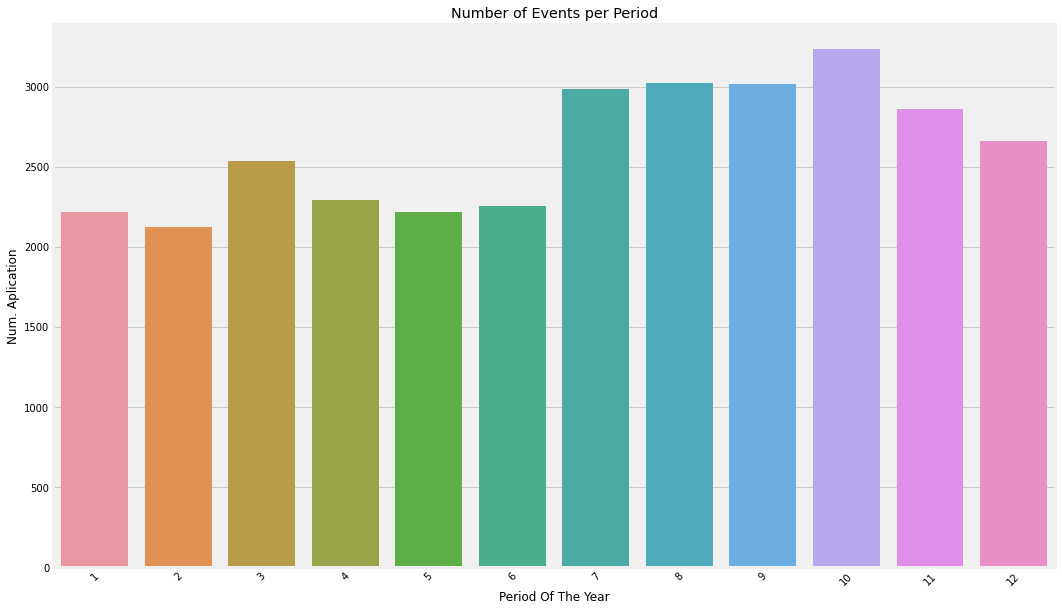

In [ ]:
fig, ax = pyplot.subplots(figsize=(16,10))
g = sns.barplot(data = events_per_month, x ='month', y= 'num_app');
g.set_xlabel('Period Of The Year')
g.set_ylabel('Num. Aplication')
g.set_title('Number of Events per Period')
pyplot.xticks(rotation=45);

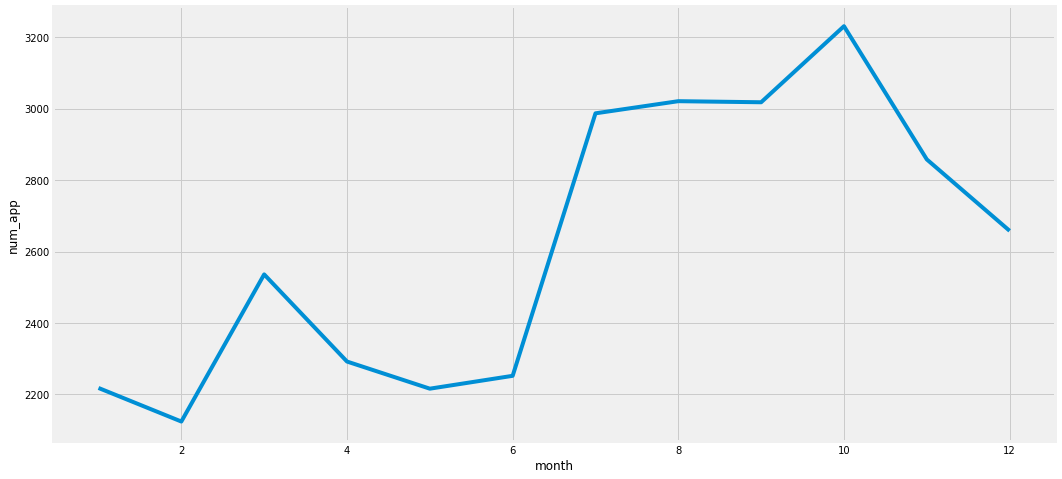

In [ ]:
plt.figure(figsize=(16, 8))
plt.tight_layout()
ax = sns.lineplot(data = events_per_month, x ='month', y= 'num_app');


## **2 Question Number** of applications per period?

###**5 - Create a features *period_of_the_year, year, month, week***

In [ ]:
df['year'] = pd.DatetimeIndex(df['end_date']).year
df['day_week'] = pd.DatetimeIndex(df['end_date']).dayofweek
df['period_of_the_year'] = pd.DatetimeIndex(df['end_date']).quarter
df['week'] = pd.DatetimeIndex(df['end_date']).strftime('%G%V')

df

,case_concept_name,start_date,end_date,month,year,day_week,period_of_the_year,week
0,Application_652823628,2016-01-01,2016-01-14,1,2016,3,1,201602
1,Application_1691306052,2016-01-01,2016-01-07,1,2016,3,1,201601
2,Application_428409768,2016-01-01,2016-01-14,1,2016,3,1,201602
3,Application_1746793196,2016-01-01,2016-01-28,1,2016,3,1,201604
4,Application_828200680,2016-01-01,2016-02-02,2,2016,1,1,201605
...,...,...,...,...,...,...,...,...
31406,Application_1331346987,2016-12-31,2017-01-23,1,2017,0,1,201704
31407,Application_1107993134,2016-12-31,2017-01-23,1,2017,0,1,201704
31408,Application_59622033,2016-12-31,2017-01-23,1,2017,0,1,201704
31409,Application_303923658,2016-12-31,2017-01-23,1,2017,0,1,201704


In [ ]:
events_per_period = df.period_of_the_year.value_counts().reset_index() \
                    .rename(index = str, columns = {'index':'period_of_the_year',
                                                    'period_of_the_year':'num_events'}) \
                    .sort_values('period_of_the_year') 
events_per_period

,period_of_the_year,num_events
2,1,6878
3,2,6760
0,3,9026
1,4,8747


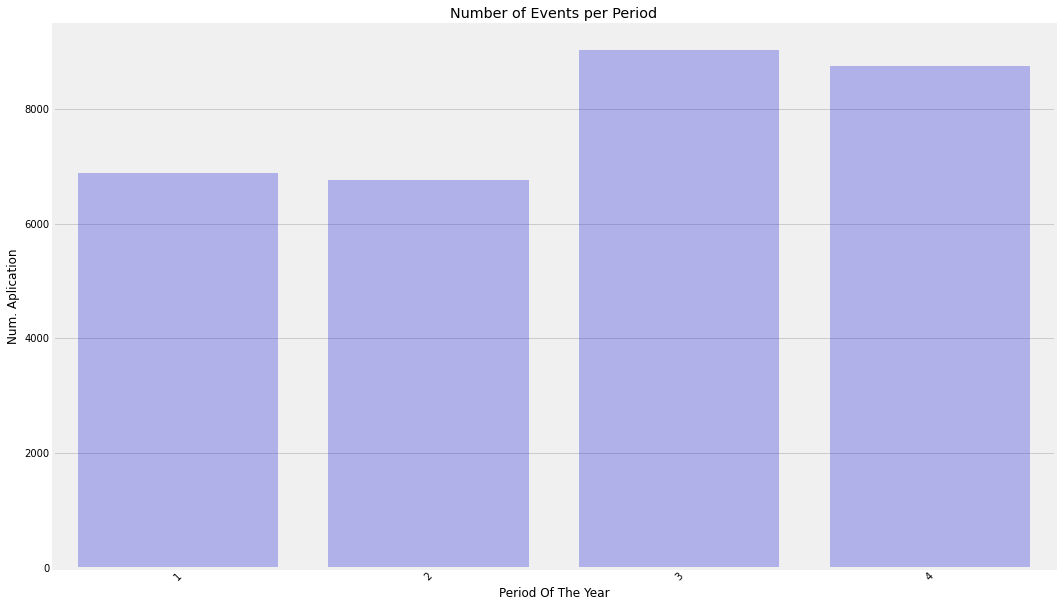

In [ ]:
fig, ax = pyplot.subplots(figsize=(16,10))
g = sns.barplot(data = events_per_period, x ='period_of_the_year', y= 'num_events',  alpha=0.3, color="blue");
g.set_xlabel('Period Of The Year')
g.set_ylabel('Num. Aplication')
g.set_title('Number of Events per Period')
pyplot.xticks(rotation=45);


### **6 - Creates the features *finished_week* adding 6 days to the start date.**

In [ ]:
df['finished_week'] = pd.to_datetime(df.start_date)
df['finished_week'] = df.finished_week.apply(lambda x : x + timedelta(days=6))
df

,case_concept_name,start_date,end_date,month,year,day_week,period_of_the_year,week,finished_week
0,Application_652823628,2016-01-01,2016-01-14,1,2016,3,1,201602,2016-01-07
1,Application_1691306052,2016-01-01,2016-01-07,1,2016,3,1,201601,2016-01-07
2,Application_428409768,2016-01-01,2016-01-14,1,2016,3,1,201602,2016-01-07
3,Application_1746793196,2016-01-01,2016-01-28,1,2016,3,1,201604,2016-01-07
4,Application_828200680,2016-01-01,2016-02-02,2,2016,1,1,201605,2016-01-07
...,...,...,...,...,...,...,...,...,...
31406,Application_1331346987,2016-12-31,2017-01-23,1,2017,0,1,201704,2017-01-06
31407,Application_1107993134,2016-12-31,2017-01-23,1,2017,0,1,201704,2017-01-06
31408,Application_59622033,2016-12-31,2017-01-23,1,2017,0,1,201704,2017-01-06
31409,Application_303923658,2016-12-31,2017-01-23,1,2017,0,1,201704,2017-01-06



### **7 - Creates the features *label* that checks if the activity was closed that week.**


In [ ]:
df['label'] = df['end_date'] <= df['finished_week']
df.sample(10)

df

,case_concept_name,start_date,end_date,month,year,day_week,period_of_the_year,week,finished_week,label
0,Application_652823628,2016-01-01,2016-01-14,1,2016,3,1,201602,2016-01-07,False
1,Application_1691306052,2016-01-01,2016-01-07,1,2016,3,1,201601,2016-01-07,True
2,Application_428409768,2016-01-01,2016-01-14,1,2016,3,1,201602,2016-01-07,False
3,Application_1746793196,2016-01-01,2016-01-28,1,2016,3,1,201604,2016-01-07,False
4,Application_828200680,2016-01-01,2016-02-02,2,2016,1,1,201605,2016-01-07,False
...,...,...,...,...,...,...,...,...,...,...
31406,Application_1331346987,2016-12-31,2017-01-23,1,2017,0,1,201704,2017-01-06,False
31407,Application_1107993134,2016-12-31,2017-01-23,1,2017,0,1,201704,2017-01-06,False
31408,Application_59622033,2016-12-31,2017-01-23,1,2017,0,1,201704,2017-01-06,False
31409,Application_303923658,2016-12-31,2017-01-23,1,2017,0,1,201704,2017-01-06,False


###Merge entre datasets

In [ ]:
#apps_duration = pd.merge(df, application_df, how='inner', on='case_concept_name')

###**Functions Windows**

# Classification

##Question: If the application was completed in the week?

In [ ]:
copy_df = df[['case_concept_name',	'start_date',	'end_date',	'month',	'year',	'day_week',	'period_of_the_year',	'label']].copy(deep=True)

copy_df.dropna(inplace=True)
copy_df.drop_duplicates(inplace=True)

copy_df

,case_concept_name,start_date,end_date,month,year,day_week,period_of_the_year,label
0,Application_652823628,2016-01-01,2016-01-14,1,2016,3,1,False
1,Application_1691306052,2016-01-01,2016-01-07,1,2016,3,1,True
2,Application_428409768,2016-01-01,2016-01-14,1,2016,3,1,False
3,Application_1746793196,2016-01-01,2016-01-28,1,2016,3,1,False
4,Application_828200680,2016-01-01,2016-02-02,2,2016,1,1,False
...,...,...,...,...,...,...,...,...
31406,Application_1331346987,2016-12-31,2017-01-23,1,2017,0,1,False
31407,Application_1107993134,2016-12-31,2017-01-23,1,2017,0,1,False
31408,Application_59622033,2016-12-31,2017-01-23,1,2017,0,1,False
31409,Application_303923658,2016-12-31,2017-01-23,1,2017,0,1,False


In [ ]:
copy_df = copy_df.fillna(0)
copy_df.isnull().sum().sort_values(ascending=False)

label                 0
period_of_the_year    0
day_week              0
year                  0
month                 0
end_date              0
start_date            0
case_concept_name     0
dtype: int64

In [ ]:
#Format Date
copy_df['start_date'] = pd.to_datetime(copy_df.start_date)
copy_df['start_date'] = copy_df['start_date'].dt.strftime('%G%V')

x = copy_df[['start_date',	'month',	'year',	'period_of_the_year']];

y= copy_df[['label']].astype('int');

#splitting data in train and test sets (70/30)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

In [ ]:
copy_df = copy_df.fillna(0)
copy_df.isnull().sum().sort_values(ascending=False)

label                 0
period_of_the_year    0
day_week              0
year                  0
month                 0
end_date              0
start_date            0
case_concept_name     0
dtype: int64

In [ ]:
copy_df = copy_df.fillna(0)
copy_df.isnull().sum().sort_values(ascending=False)

label                 0
period_of_the_year    0
day_week              0
year                  0
month                 0
end_date              0
start_date            0
case_concept_name     0
dtype: int64

###Function Model Accuracy

In [ ]:
def get_model_accuracy(clf_name, clf):
    training_accry = clf.score(x_train, y_train)
    test_accry = clf.score(x_test, y_test)

    clf_str = 'Acurracy of {} classifer on'.format(clf_name)
    model_acurracy_str = '{} {} set {:.2f}\n{} {} set {:.2f}'.format(
        clf_str, 'training', training_accry, clf_str, 'test', test_accry)

    return model_acurracy_str

####Logic Regression

In [ ]:
logreg = LogisticRegression()
logreg.fit(x_train, y_train)

print(get_model_accuracy('Logistic Regression', logreg))

Acurracy of Logistic Regression classifer on training set 0.95
Acurracy of Logistic Regression classifer on test set 0.95


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


###Random Forest

In [ ]:
clf = RandomForestClassifier(n_estimators=100, random_state=0)

#Train the model using 
clf.fit(x_train,y_train)

y_pred=clf.predict(x_test)

print(get_model_accuracy('Logistic Regression', clf))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


Acurracy of Logistic Regression classifer on training set 0.95
Acurracy of Logistic Regression classifer on test set 0.95


###Decision Tree

In [ ]:
clf = DecisionTreeClassifier().fit(x_train, y_train)

print(get_model_accuracy('Decision Tree', clf))

Acurracy of Decision Tree classifer on training set 0.95
Acurracy of Decision Tree classifer on test set 0.95


###K-Nearest Neighbors

In [ ]:
knn = KNeighborsClassifier()
knn.fit(x_train, y_train)

print(get_model_accuracy('K-NN', knn))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


Acurracy of K-NN classifer on training set 0.95
Acurracy of K-NN classifer on test set 0.94


###Linear Discriminant Analysis

In [ ]:
lda = LinearDiscriminantAnalysis()
lda.fit(x_train, y_train)

print(get_model_accuracy('LDA', lda))

Acurracy of LDA classifer on training set 0.95
Acurracy of LDA classifer on test set 0.95


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


###Gaussian Naive Bayes

In [ ]:
gnb = GaussianNB()
gnb.fit(x_train, y_train)

print(get_model_accuracy('GNB', gnb))

Acurracy of GNB classifer on training set 0.95
Acurracy of GNB classifer on test set 0.95


/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



###Model evaluation

- Accuracy: the ratio of correctly predicted observation to the total observations
- Precision: proportion of positive identifications that was actually correct
- Recall: proportion of actual positives that was identified correctly
- F1 Score: weighted average of Precision and Recall

In [ ]:
print('Precision score: {0:0.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Recall score: {0:0.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Average precision-recall score: {0:0.2f}'.format(average_precision_score(y_test, y_pred)))
print('Average F1 Score score: {0:0.2f}'.format(metrics.f1_score(y_test, y_pred)))



Precision score: 0.87
Recall score: 0.56
Average precision-recall score: 0.14
Average F1 Score score: 0.21


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      8908
           1       0.79      0.12      0.21       516

    accuracy                           0.95      9424
   macro avg       0.87      0.56      0.59      9424
weighted avg       0.94      0.95      0.93      9424



###Confusion Matrix



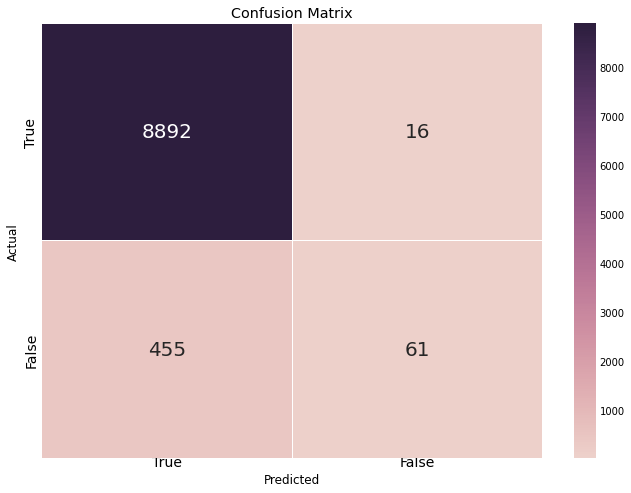

In [ ]:
plt.figure(figsize=(10,8))
ax = (sns.heatmap(metrics.confusion_matrix(y_test, y_pred), annot=True, annot_kws={"size": 20}, 
                 linewidths=.1, fmt='d', cmap=sns.cubehelix_palette(as_cmap=True)))
plt.yticks([0.5,1.5,2], ['True', 'False'], va='center', fontsize=14)
plt.xticks([0.5,1.5,2], ['True', 'False'], va='center', fontsize=14)
ax.set_title("Confusion Matrix")
ax.set(xlabel="Predicted", ylabel="Actual");
plt.show()

###Features import

([<matplotlib.axis.XTick at 0x7f390d790d68>,
 [Text(0, 0, 'start_date'),
  Text(0, 0, 'month'),
  Text(0, 0, 'year'),
  Text(0, 0, 'period_of_the_year')])

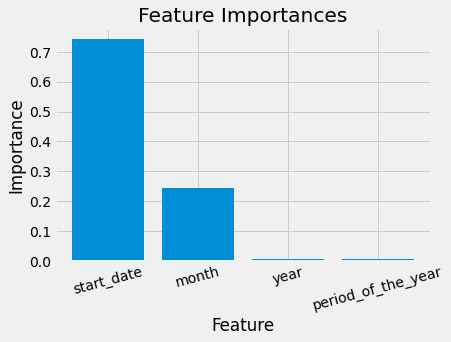

In [ ]:
feature_list = ['start_date',	'month',	'year',	'period_of_the_year']
feature_imp = pd.Series(clf.feature_importances_,index=feature_list)

plt.style.use('fivethirtyeight')
x_values = list(range(len(feature_imp)))
plt.bar(x_values, feature_imp, orientation = 'vertical')
plt.xticks(x_values, feature_list)

plt.ylabel('Importance'); plt.xlabel('Feature'); plt.title('Feature Importances')
plt.xticks(x_values, feature_list, rotation='15')


#**Conclusion**

##Our best model was a RandomForest that achieved 95% accuracy in our test data set. The best characteristics were the accumulated start_date and month.